# RKHS-SHAP on California Housing Dataset

This notebook demonstrates exact RKHS-SHAP versus Kernel SHAP on the California housing dataset using Gaussian Process regression.

## Overview
- **Dataset**: California housing (8 features)
- **Model**: ExactGPModel with RBF kernel
- **Analysis**: Kernel SHAP vs Interventional RKHS-SHAP

In [1]:
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from rkhs_shap.exact_gp import ExactGPModel
from rkhs_shap.rkhs_shap_exact import RKHSSHAP

plt.style.use("default")
sns.set_palette("husl")
%matplotlib inline

warnings.filterwarnings("ignore")

# large, only rkhs
SAMPLE_SIZES = [100, 250, 500, 1000, 5000, 10000]
KERNEL_SHAP_MAX_SAMPLES = 10
EXPLAIN_SIZE: int | None = None

# fast, both
# SAMPLE_SIZES = [100, 250, 500, 1000]
# KERNEL_SHAP_MAX_SAMPLES = 500
# EXPLAIN_SIZE: int | None = 20

VAL_SAMPLE_SIZE = 500
BACKGROUND_SIZE = 100
RANDOM_STATE = 42

print(f"Sample sizes to analyze: {SAMPLE_SIZES}")

Sample sizes to analyze: [100, 250, 500, 1000, 5000, 10000]


## Load and Prepare Dataset

In [2]:
def load_scaled_dataset(n_train: int, n_val: int = VAL_SAMPLE_SIZE):
    """Load and scale California housing dataset."""
    X, y = shap.datasets.california()
    rng = np.random.default_rng(RANDOM_STATE)

    n_indices = n_train + n_val
    both_indices = rng.choice(len(X), size=n_indices, replace=False)
    train_indices = both_indices[:n_train]
    val_indices = both_indices[n_train:]

    X_train = X.iloc[train_indices].values
    y_train = y[train_indices]
    X_val = X.iloc[val_indices].values
    y_val = y[val_indices]

    feature_scaler = MinMaxScaler()
    X_train = feature_scaler.fit_transform(X_train)
    X_val = feature_scaler.transform(X_val)

    target_scaler = StandardScaler()
    # target_scaler = MinMaxScaler()
    y_train = target_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_val = target_scaler.transform(y_val.reshape(-1, 1)).flatten()

    print(
        f"y_train mean: {y_train.mean():.4f}, range: [{y_train.min():.4f}, {y_train.max():.4f}]"
    )

    return X_train, y_train, X_val, y_val


X_full, y_full, X_scaled, y_scaled = load_scaled_dataset(20640 - VAL_SAMPLE_SIZE)

feature_names = shap.datasets.california()[0].columns.tolist()

print(f"Full dataset shape: {X_full.shape}")
print(f"Features: {feature_names}")

y_train mean: 0.0000, range: [-1.6632, 2.5450]
Full dataset shape: (20140, 8)
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [3]:
from rkhs_shap.utils import calculate_additivity_mae, calculate_correlation, to_tensor


def train_gp_model(X_train: np.ndarray, y_train: np.ndarray, training_iter: int = 50):
    train_x = to_tensor(X_train)
    train_y = to_tensor(y_train)
    model = ExactGPModel(train_x, train_y)
    model.fit(training_iter=training_iter, lr=0.1)
    return model


def run_kernel_shap(model, X_background, X_explain, feature_names):
    """Run Kernel SHAP on the GP model."""
    start_time = time.time()
    explainer = shap.KernelExplainer(
        model=model.predict_mean_numpy,
        data=X_background,
        feature_names=feature_names,
    )
    explanation = explainer(X_explain)
    shap_time = time.time() - start_time

    return explanation, shap_time


def run_rkhs_shap(
    model: ExactGPModel,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_explain: np.ndarray,
) -> tuple[np.ndarray, float]:
    """Run exact RKHS-SHAP (Interventional) on the GP model."""
    start_time = time.time()

    train_x = to_tensor(X_train)
    train_y = to_tensor(y_train)
    noise_var = model.likelihood.noise.detach().cpu().float()

    rkhs_shap = RKHSSHAP(
        X=train_x,
        y=train_y,
        kernel=model.covar_module,
        noise_var=noise_var,
        cme_reg=1e-4,
        mean_function=model.mean_module,
    )

    X_explain_tensor = to_tensor(X_explain)
    shap_values = rkhs_shap.fit(
        X_test=X_explain_tensor,
        method="I",  # Interventional
        sample_method="full",
    )

    shap_time = time.time() - start_time
    return shap_values, shap_time


def compute_accuracy_metrics(
    kernel_shap, rkhs_shap, model_predictions, baseline: float
):
    """Compare RKHS-SHAP and Kernel SHAP accuracy."""
    if kernel_shap is None:
        kernel_values = np.zeros_like(rkhs_shap)
    else:
        kernel_values = kernel_shap.values

    kernel_additivity_errors = calculate_additivity_mae(
        kernel_values, to_tensor(model_predictions), baseline
    )
    rkhs_additivity_errors = calculate_additivity_mae(
        rkhs_shap, to_tensor(model_predictions), baseline
    )

    correlation = calculate_correlation(kernel_values, rkhs_shap)
    mse = np.mean((kernel_values - rkhs_shap) ** 2)

    if kernel_shap is None:
        kernel_additivity_errors = [np.nan] * len(rkhs_shap)
        mse = np.nan
    return {
        "kernel_additivity_mae": np.mean(kernel_additivity_errors),
        "rkhs_additivity_mae": np.mean(rkhs_additivity_errors),
        "methods_correlation": correlation,
        "methods_mse": mse,
    }

In [4]:
all_metrics = []
all_kernel_explanations = []
all_rkhs_explanations = []
all_models = []
all_scalers = []
rng = np.random.default_rng(RANDOM_STATE)

for sample_size in SAMPLE_SIZES:
    print(f"\n{'=' * 70}")
    print(f"Analyzing sample size: {sample_size}")
    print(f"{'=' * 70}")

    X_train, y_train, X_val, y_val = load_scaled_dataset(sample_size)

    print("Training GP model...")
    start_time = time.time()
    model = train_gp_model(X_train, y_train)
    all_models.append(model)
    training_time = time.time() - start_time
    print(f"Training time: {training_time:.2f}s")

    y_pred = model.predict_mean_numpy(X_val)
    r2 = r2_score(y_val, y_pred)
    print(f"Model R² on validation set: {r2:.4f}")
    print(f"Learned mean function: {model.mean_module.constant.item():.4f}")

    if EXPLAIN_SIZE is not None:
        X_explain = X_train[:EXPLAIN_SIZE]  # Explain first EXPLAIN_SIZE points
    else:
        X_explain = X_train  # Explain all points
    print(f"Explaining {X_explain.shape[0]} points")

    if sample_size > KERNEL_SHAP_MAX_SAMPLES:
        # Run Kernel SHAP
        print(
            f"Skipping Kernel SHAP for sample size {sample_size} > {KERNEL_SHAP_MAX_SAMPLES})"
        )
        kernel_explanation = None
        kernel_shap_time = np.nan
    else:
        print("Running Kernel SHAP...")
        background_indices = rng.choice(
            len(X_train), size=BACKGROUND_SIZE, replace=False
        )
        X_background = X_train[background_indices]
        print(f"KernelSHAP background size: {X_background.shape[0]}")
        kernel_explanation, kernel_shap_time = run_kernel_shap(
            model, X_background, X_explain, feature_names
        )
        print(f"Kernel SHAP time: {kernel_shap_time:.2f}s")
    all_kernel_explanations.append(kernel_explanation)

    # Run RKHS-SHAP
    print("Running RKHS-SHAP...")
    rkhs_shap_values, rkhs_shap_time = run_rkhs_shap(model, X_train, y_train, X_explain)
    print(f"RKHS-SHAP time: {rkhs_shap_time:.2f}s")
    all_rkhs_explanations.append(rkhs_shap_values)

    # Note: Predictions take quite long for large datasets
    pred_explain = model.predict_mean_numpy(X_explain)
    baseline = model.predict_mean_numpy(X_train).mean()
    accuracy_metrics = compute_accuracy_metrics(
        kernel_explanation,
        rkhs_shap_values,
        pred_explain,
        baseline,
    )

    print(f"Model prediction baseline: {baseline:.4f}")
    print(f"Methods correlation: {accuracy_metrics['methods_correlation']:.3f}")
    print(f"Kernel additivity MAE: {accuracy_metrics['kernel_additivity_mae']:.4f}")
    print(f"RKHS additivity MAE: {accuracy_metrics['rkhs_additivity_mae']:.4f}")

    # Store metrics
    metrics = {
        "sample_size": sample_size,
        "training_time": training_time,
        "model_r2": r2,
        "kernel_shap_time": kernel_shap_time,
        "rkhs_shap_time": rkhs_shap_time,
        **accuracy_metrics,
    }
    all_metrics.append(metrics)

metrics_df = pd.DataFrame(all_metrics)
print(f"\n{'=' * 70}")
print("Analysis complete!")
print(f"{'=' * 70}")


Analyzing sample size: 100
y_train mean: -0.0000, range: [-1.3765, 2.5858]
Training GP model...
iter 1/50 - loss: 1.095 {} noise: 0.693
iter 10/50 - loss: 0.866 {} noise: 0.342
iter 20/50 - loss: 0.750 {} noise: 0.156
iter 30/50 - loss: 0.744 {} noise: 0.110
iter 40/50 - loss: 0.733 {} noise: 0.125
iter 50/50 - loss: 0.730 {} noise: 0.143
Training time: 0.64s
Model R² on validation set: 0.6696
Learned mean function: 0.5180
Explaining 100 points
Skipping Kernel SHAP for sample size 100 > 10)
Running RKHS-SHAP...


100%|██████████| 256/256 [00:00<00:00, 684.60it/s]


RKHS-SHAP time: 0.39s
predicting explain points for accuracy metrics...
predicting train points for baseline...
computing accuracy metrics...
Model prediction baseline: -0.0004
Methods correlation: nan
Kernel additivity MAE: nan
RKHS additivity MAE: 0.0000

Analyzing sample size: 250
y_train mean: -0.0000, range: [-1.3842, 2.3035]
Training GP model...
iter 1/50 - loss: 1.080 {} noise: 0.693
iter 10/50 - loss: 0.925 {} noise: 0.347
iter 20/50 - loss: 0.901 {} noise: 0.203
iter 30/50 - loss: 0.890 {} noise: 0.237
iter 40/50 - loss: 0.891 {} noise: 0.273
iter 50/50 - loss: 0.888 {} noise: 0.244
Training time: 0.13s
Model R² on validation set: 0.7109
Learned mean function: 0.3919
Explaining 250 points
Skipping Kernel SHAP for sample size 250 > 10)
Running RKHS-SHAP...


100%|██████████| 256/256 [00:00<00:00, 728.62it/s]


RKHS-SHAP time: 0.36s
predicting explain points for accuracy metrics...
predicting train points for baseline...
computing accuracy metrics...
Model prediction baseline: 0.0001
Methods correlation: nan
Kernel additivity MAE: nan
RKHS additivity MAE: 0.0000

Analyzing sample size: 500
y_train mean: -0.0000, range: [-1.3934, 2.4511]
Training GP model...
iter 1/50 - loss: 1.048 {} noise: 0.693
iter 10/50 - loss: 0.893 {} noise: 0.347
iter 20/50 - loss: 0.850 {} noise: 0.192
iter 30/50 - loss: 0.846 {} noise: 0.186
iter 40/50 - loss: 0.842 {} noise: 0.209
iter 50/50 - loss: 0.841 {} noise: 0.217
Training time: 0.25s
Model R² on validation set: 0.7095
Learned mean function: 0.1583
Explaining 500 points
Skipping Kernel SHAP for sample size 500 > 10)
Running RKHS-SHAP...


100%|██████████| 256/256 [00:00<00:00, 435.94it/s]


RKHS-SHAP time: 0.59s
predicting explain points for accuracy metrics...
predicting train points for baseline...
computing accuracy metrics...
Model prediction baseline: 0.0001
Methods correlation: nan
Kernel additivity MAE: nan
RKHS additivity MAE: 0.0000

Analyzing sample size: 1000
y_train mean: 0.0000, range: [-1.4369, 2.5268]
Training GP model...
iter 1/50 - loss: 1.013 {} noise: 0.693
iter 10/50 - loss: 0.845 {} noise: 0.346
iter 20/50 - loss: 0.762 {} noise: 0.181
iter 30/50 - loss: 0.791 {} noise: 0.147
iter 40/50 - loss: 0.789 {} noise: 0.132
iter 50/50 - loss: 0.784 {} noise: 0.124
Training time: 0.64s
Model R² on validation set: 0.7279
Learned mean function: -0.1617
Explaining 1000 points
Skipping Kernel SHAP for sample size 1000 > 10)
Running RKHS-SHAP...


100%|██████████| 256/256 [00:01<00:00, 198.72it/s]


RKHS-SHAP time: 1.30s
predicting explain points for accuracy metrics...
predicting train points for baseline...
computing accuracy metrics...
Model prediction baseline: -0.0001
Methods correlation: nan
Kernel additivity MAE: nan
RKHS additivity MAE: 0.0059

Analyzing sample size: 5000
y_train mean: -0.0000, range: [-1.6596, 2.5478]
Training GP model...
iter 1/50 - loss: 1.000 {} noise: 0.693
iter 10/50 - loss: 0.819 {} noise: 0.346
iter 20/50 - loss: 0.692 {} noise: 0.181
iter 30/50 - loss: 0.586 {} noise: 0.108
iter 40/50 - loss: 0.583 {} noise: 0.056
iter 50/50 - loss: 0.659 {} noise: 0.031
Training time: 10.81s
Model R² on validation set: 0.7735
Learned mean function: -0.1379
Explaining 5000 points
Skipping Kernel SHAP for sample size 5000 > 10)
Running RKHS-SHAP...


100%|██████████| 256/256 [00:13<00:00, 19.59it/s]


RKHS-SHAP time: 13.23s
predicting explain points for accuracy metrics...
predicting train points for baseline...
computing accuracy metrics...
Model prediction baseline: -0.0001
Methods correlation: nan
Kernel additivity MAE: nan
RKHS additivity MAE: 0.0066

Analyzing sample size: 10000
y_train mean: -0.0000, range: [-1.6631, 2.5495]
Training GP model...
iter 1/50 - loss: 1.004 {} noise: 0.693
iter 10/50 - loss: 0.856 {} noise: 0.349
iter 20/50 - loss: 0.738 {} noise: 0.200
iter 30/50 - loss: 0.601 {} noise: 0.130
iter 40/50 - loss: 0.593 {} noise: 0.076
iter 50/50 - loss: 0.626 {} noise: 0.042
Training time: 45.16s
Model R² on validation set: 0.7875
Learned mean function: -0.1306
Explaining 10000 points
Skipping Kernel SHAP for sample size 10000 > 10)
Running RKHS-SHAP...


100%|██████████| 256/256 [00:59<00:00,  4.34it/s]


RKHS-SHAP time: 60.40s
predicting explain points for accuracy metrics...
predicting train points for baseline...
computing accuracy metrics...
Model prediction baseline: 0.0012
Methods correlation: nan
Kernel additivity MAE: nan
RKHS additivity MAE: 0.0069

Analysis complete!


## Visualize Results

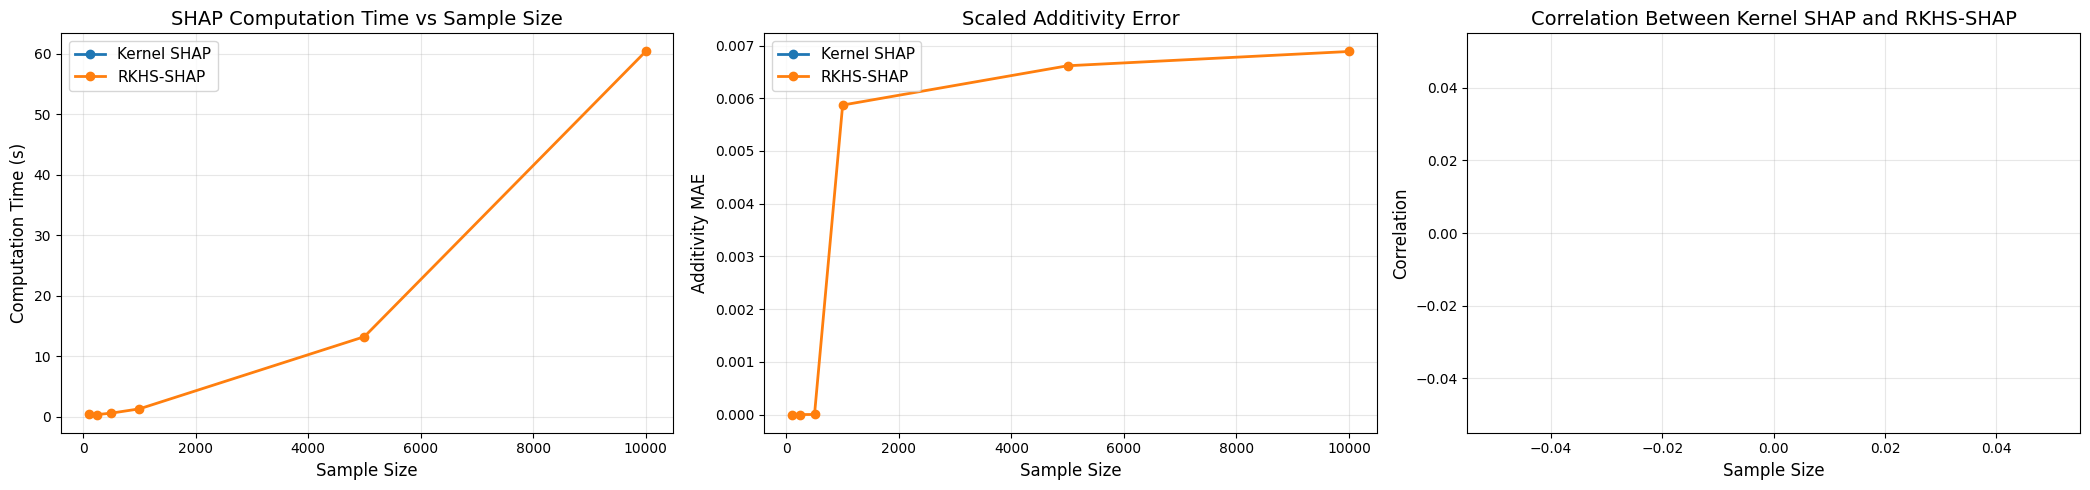


Metrics Summary:
 sample_size  training_time  model_r2  kernel_shap_time  rkhs_shap_time  kernel_additivity_mae  rkhs_additivity_mae  methods_correlation  methods_mse
         100       0.638726  0.669612               NaN        0.390740                    NaN             0.000002                  NaN          NaN
         250       0.130471  0.710864               NaN        0.355662                    NaN             0.000002                  NaN          NaN
         500       0.249353  0.709537               NaN        0.592578                    NaN             0.000004                  NaN          NaN
        1000       0.638326  0.727853               NaN        1.299577                    NaN             0.005871                  NaN          NaN
        5000      10.812861  0.773511               NaN       13.234959                    NaN             0.006616                  NaN          NaN
       10000      45.158290  0.787537               NaN       60.397297           

In [5]:
# Performance comparison plots
kernel_color = "#1f77b4"  # Blue
rkhs_color = "#ff7f0e"  # Orange

fig, axs = plt.subplots(1, 3, figsize=(21, 5))

# Computation time
axs[0].plot(
    metrics_df["sample_size"],
    metrics_df["kernel_shap_time"],
    marker="o",
    label="Kernel SHAP",
    color=kernel_color,
    linewidth=2,
)
axs[0].plot(
    metrics_df["sample_size"],
    metrics_df["rkhs_shap_time"],
    marker="o",
    label="RKHS-SHAP",
    color=rkhs_color,
    linewidth=2,
)
axs[0].set_xlabel("Sample Size", fontsize=12)
axs[0].set_ylabel("Computation Time (s)", fontsize=12)
axs[0].set_title("SHAP Computation Time vs Sample Size", fontsize=14)
axs[0].legend(fontsize=11)
axs[0].grid(True, alpha=0.3)

# Additivity error
axs[1].plot(
    metrics_df["sample_size"],
    metrics_df["kernel_additivity_mae"],
    marker="o",
    label="Kernel SHAP",
    color=kernel_color,
    linewidth=2,
)
axs[1].plot(
    metrics_df["sample_size"],
    metrics_df["rkhs_additivity_mae"],
    marker="o",
    label="RKHS-SHAP",
    color=rkhs_color,
    linewidth=2,
)
axs[1].set_xlabel("Sample Size", fontsize=12)
axs[1].set_ylabel("Additivity MAE", fontsize=12)
axs[1].set_title("Scaled Additivity Error", fontsize=14)
axs[1].legend(fontsize=11)
axs[1].grid(True, alpha=0.3)

# Correlation
axs[2].plot(
    metrics_df["sample_size"],
    metrics_df["methods_correlation"],
    marker="o",
    color="purple",
    linewidth=2,
)
axs[2].set_xlabel("Sample Size", fontsize=12)
axs[2].set_ylabel("Correlation", fontsize=12)
axs[2].set_title("Correlation Between Kernel SHAP and RKHS-SHAP", fontsize=14)
# axs[2].set_ylim(0, 1.05)
axs[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nMetrics Summary:")
print(metrics_df.to_string(index=False))

## SHAP Value Comparison for Each Sample Size

Error plotting RKHS-SHAP explanations: 'NoneType' object has no attribute 'data'


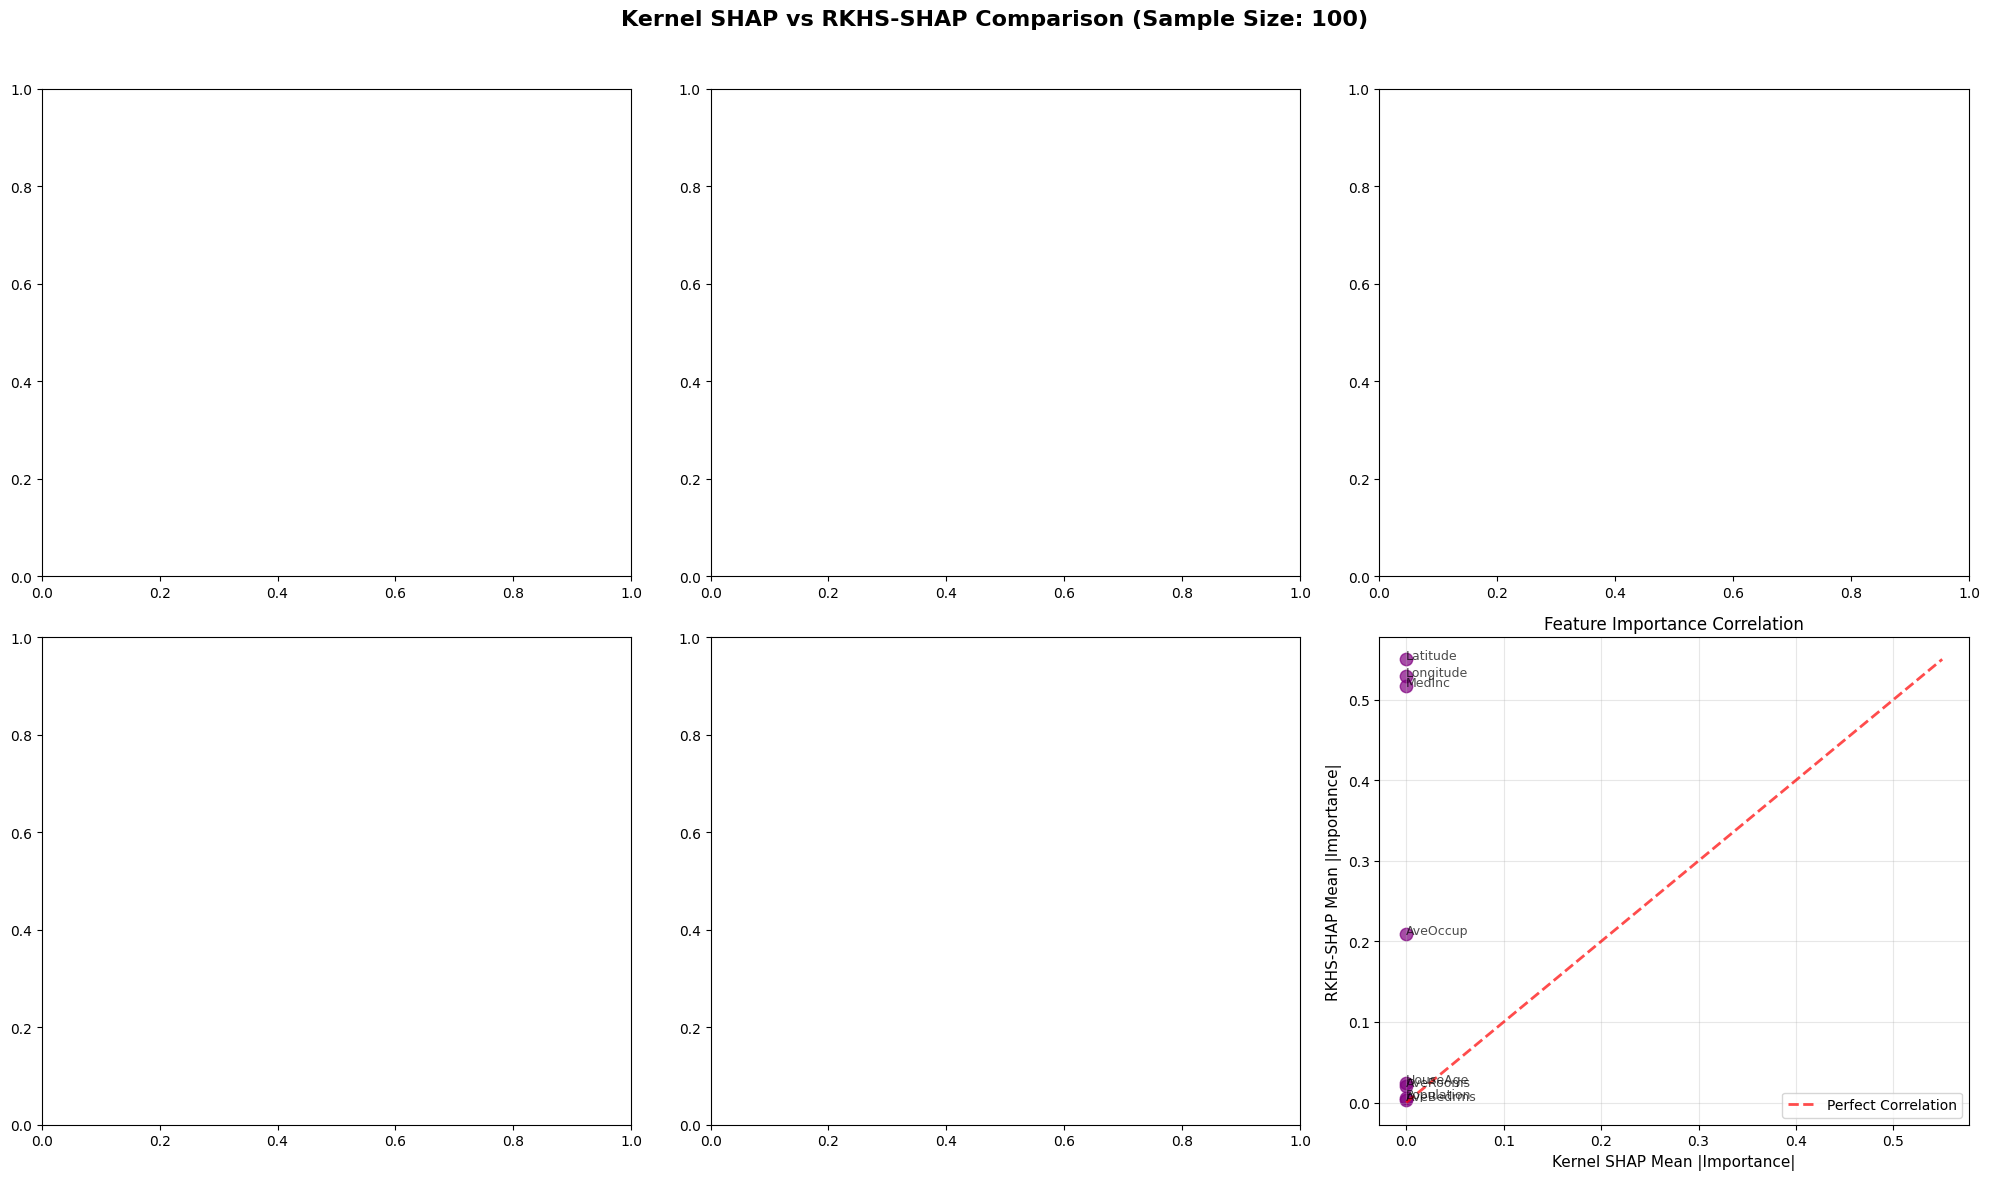

Error plotting RKHS-SHAP explanations: 'NoneType' object has no attribute 'data'


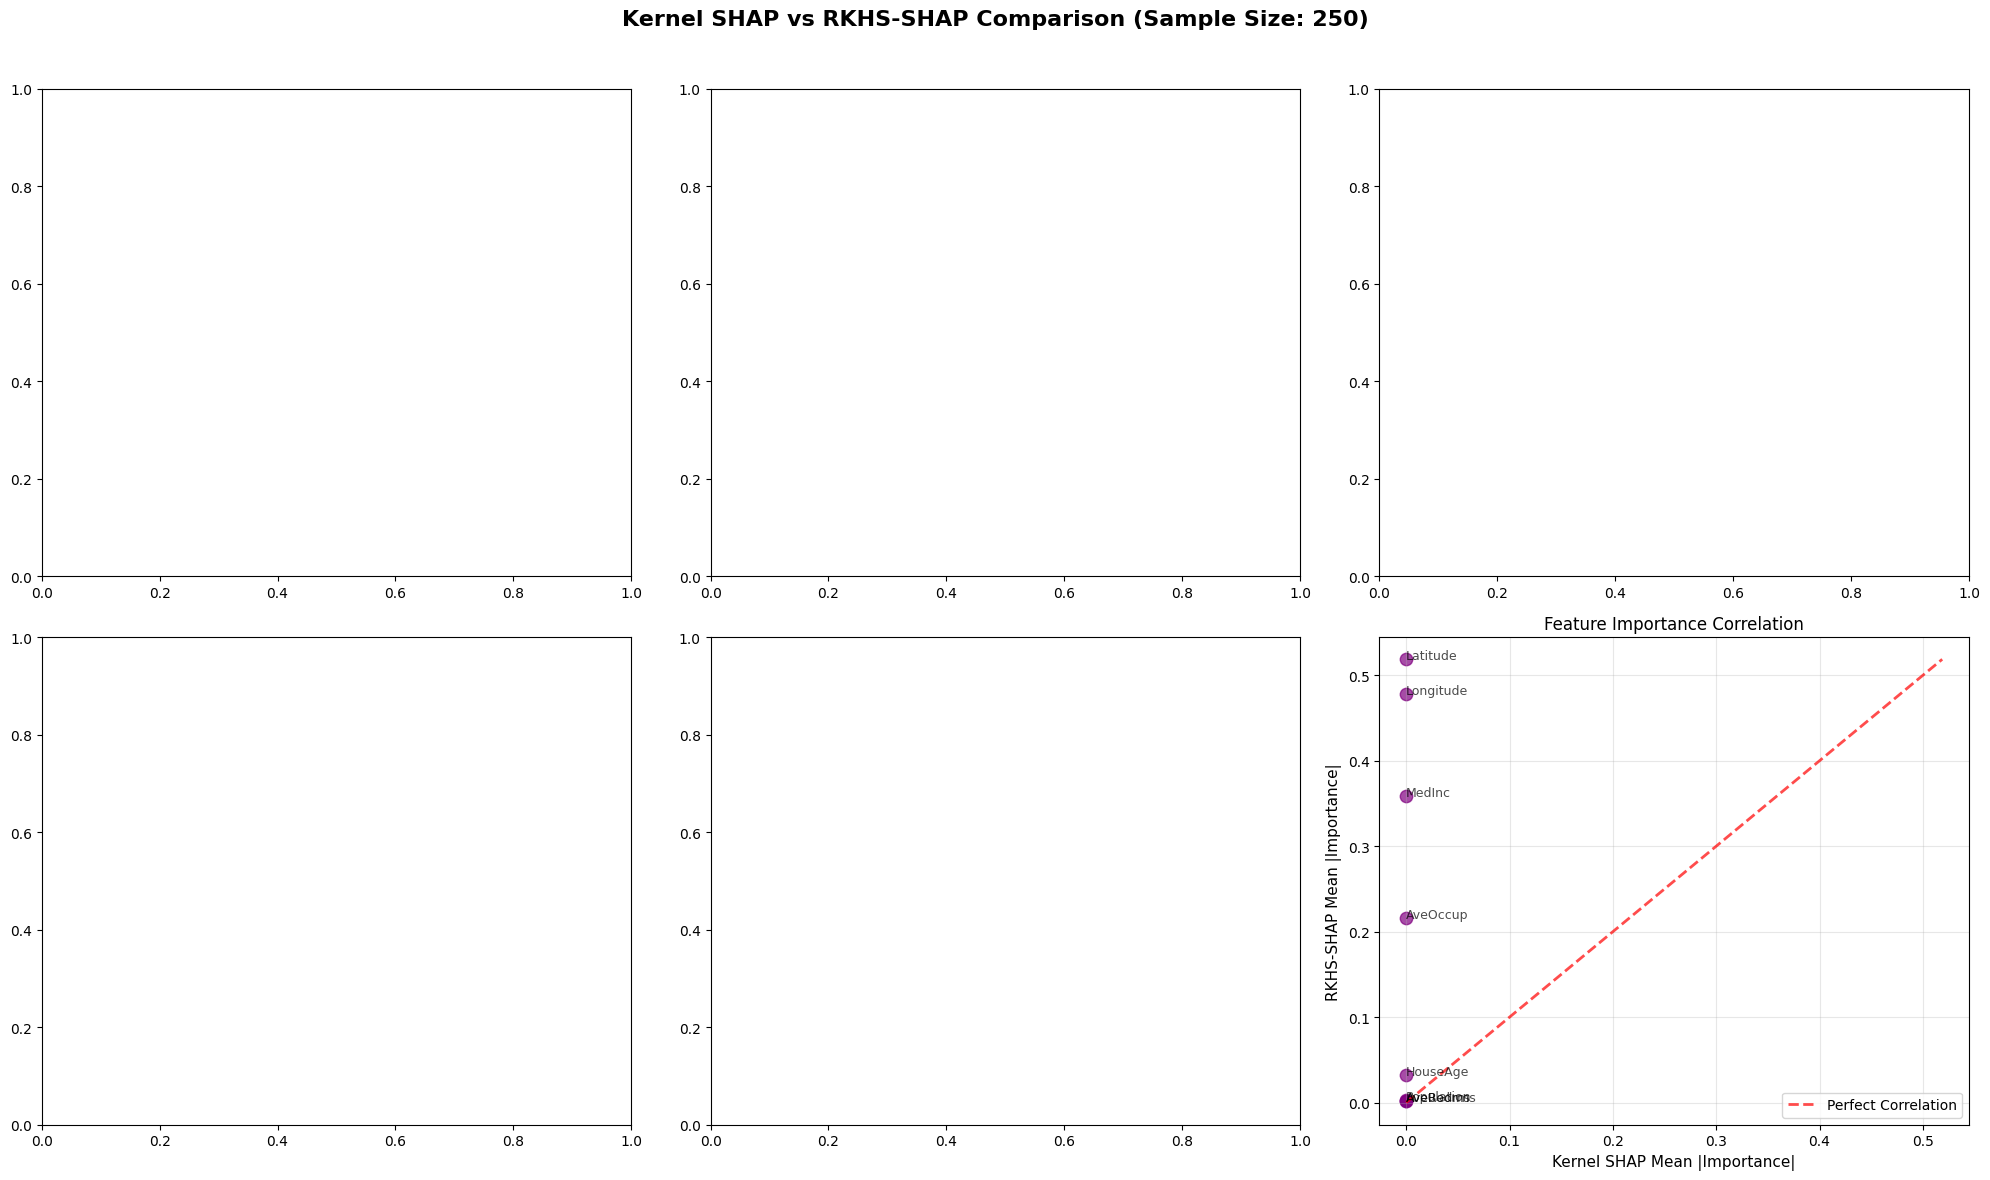

Error plotting RKHS-SHAP explanations: 'NoneType' object has no attribute 'data'


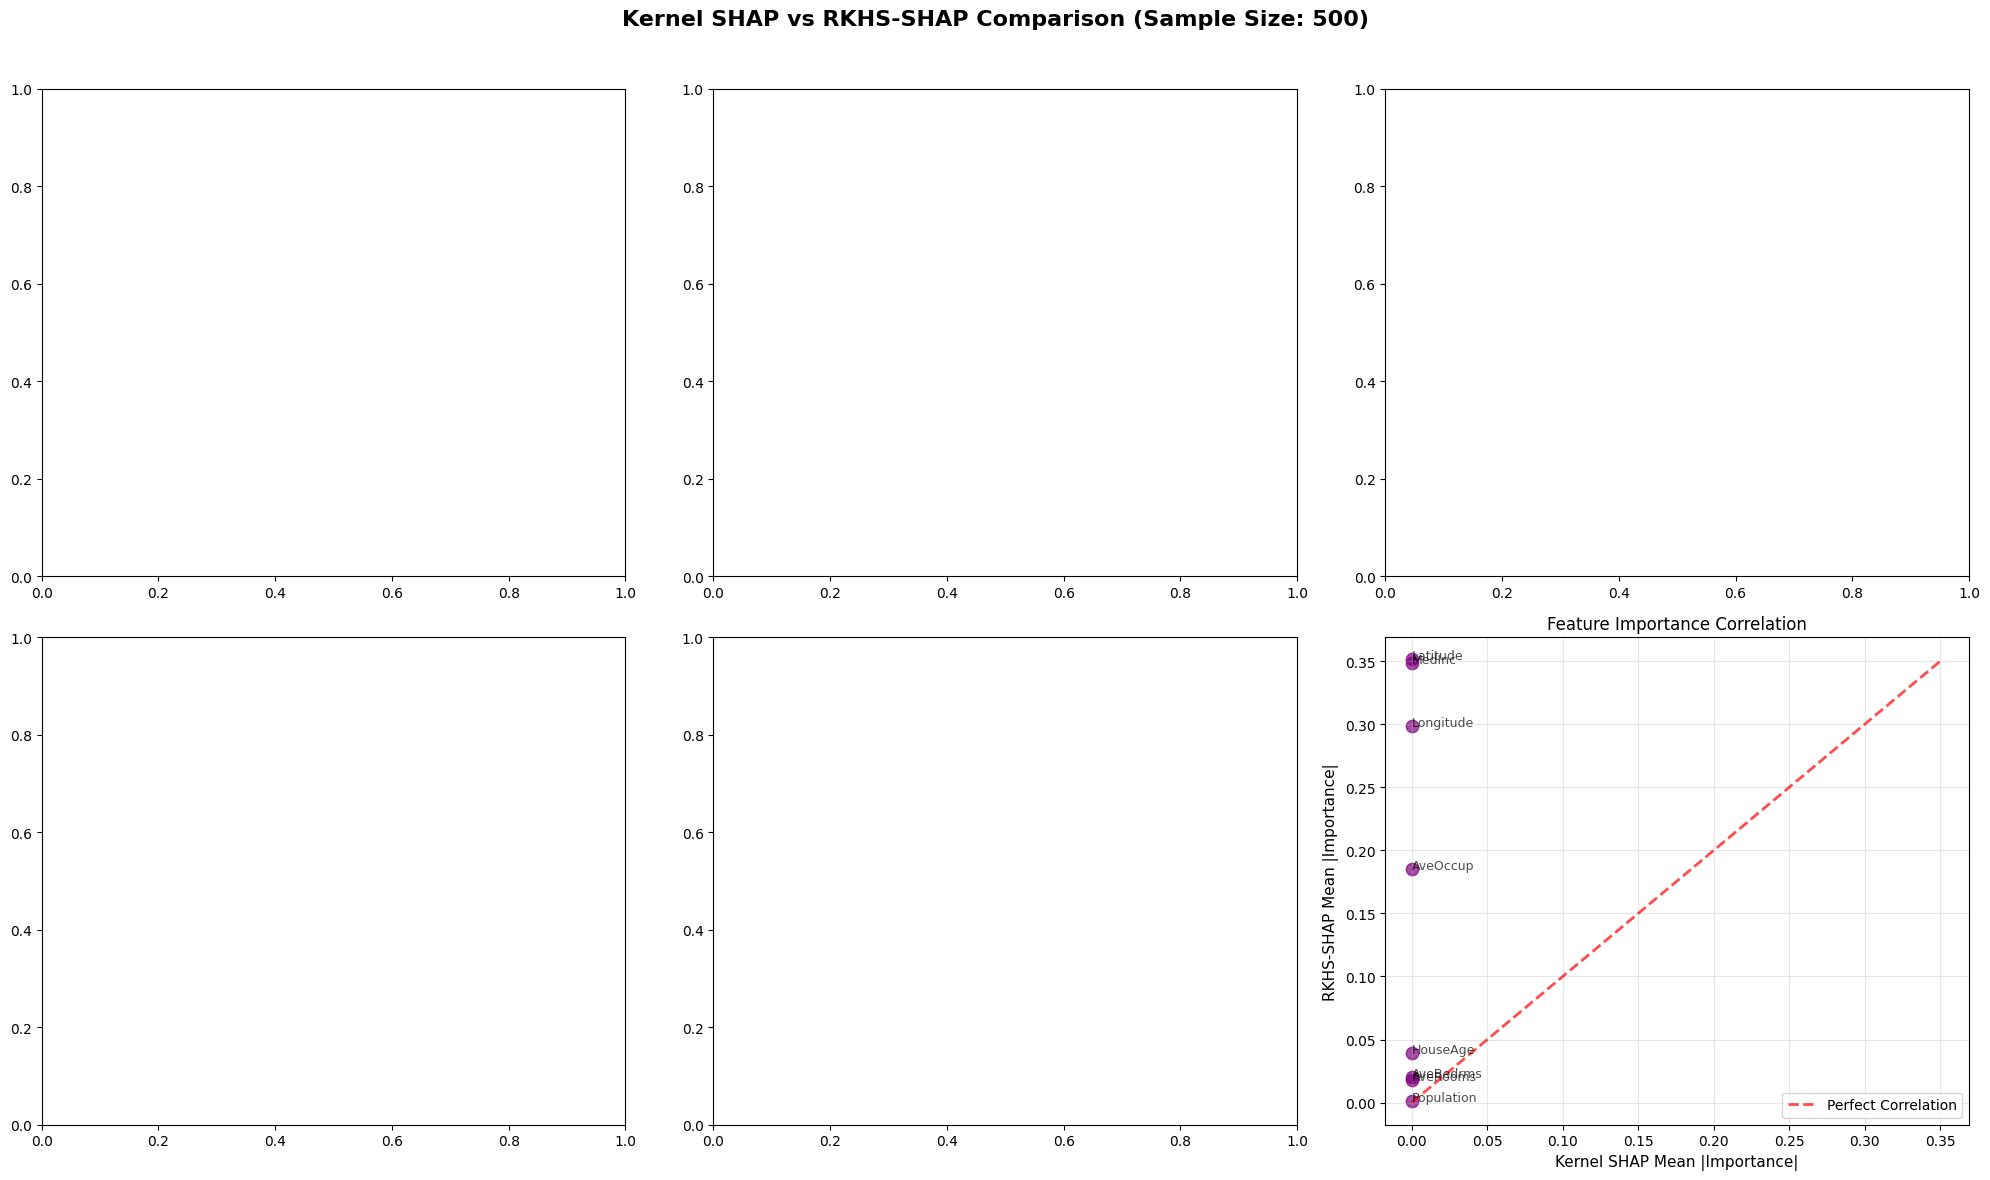

Error plotting RKHS-SHAP explanations: 'NoneType' object has no attribute 'data'


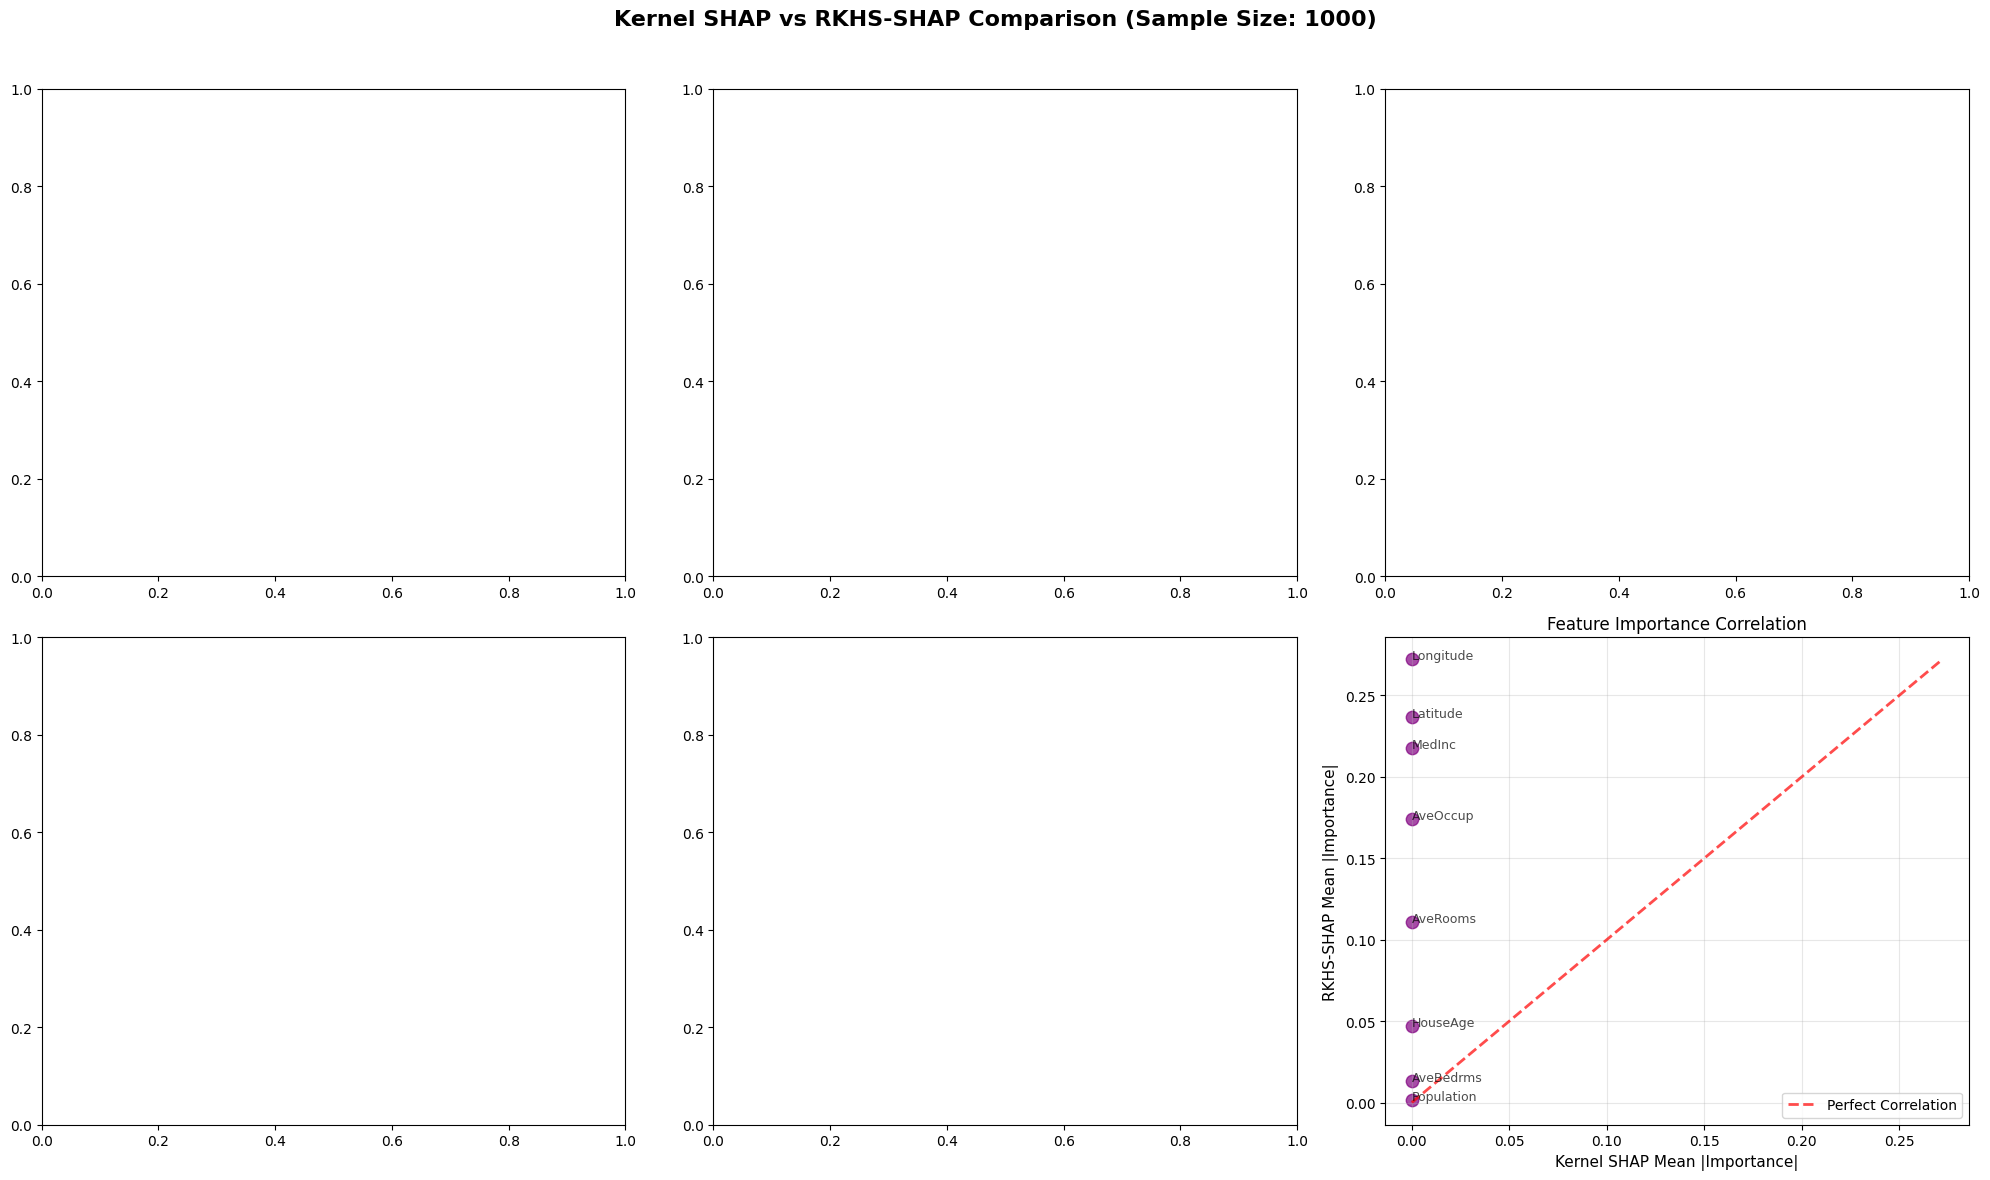

Error plotting RKHS-SHAP explanations: 'NoneType' object has no attribute 'data'


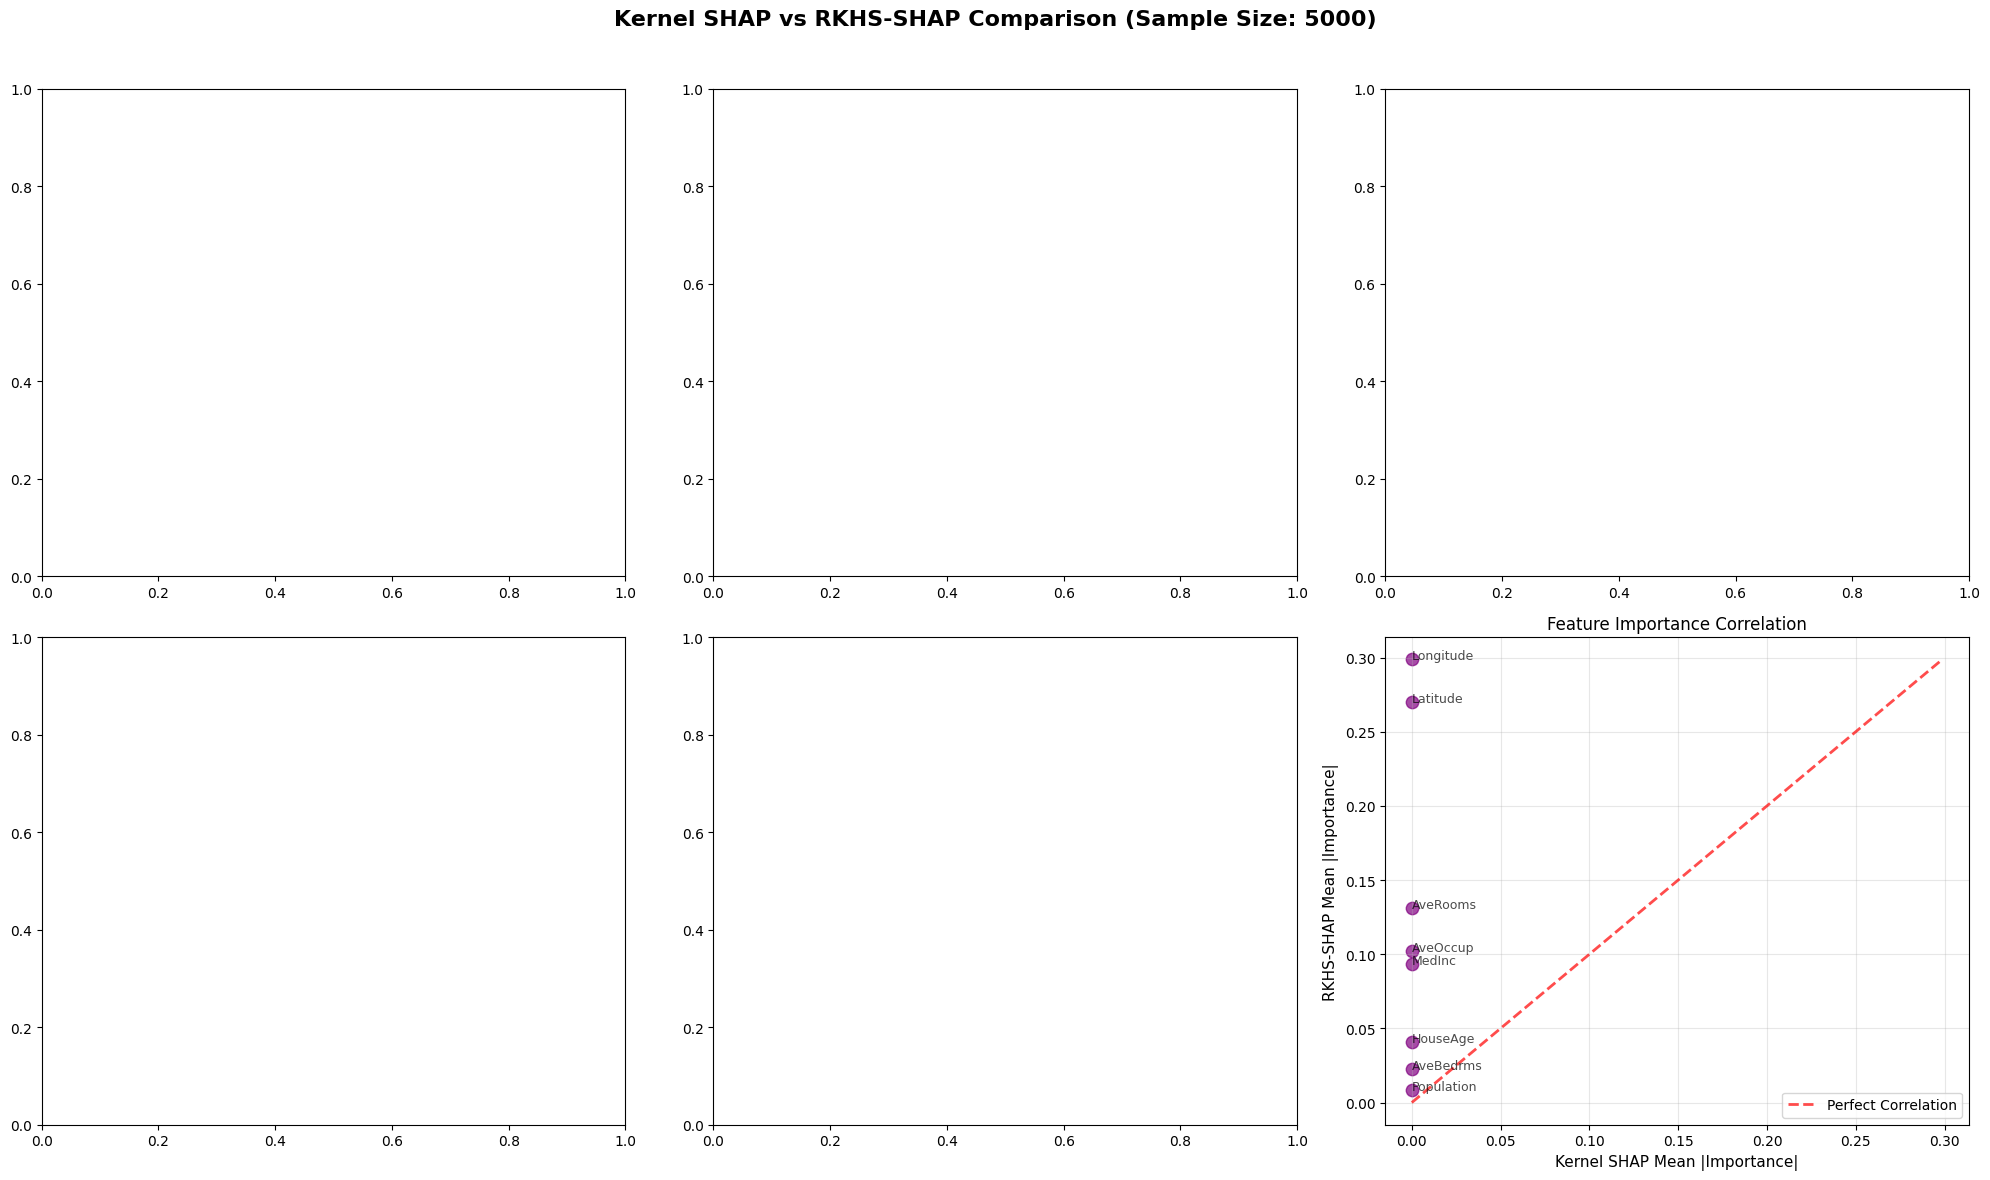

Error plotting RKHS-SHAP explanations: 'NoneType' object has no attribute 'data'


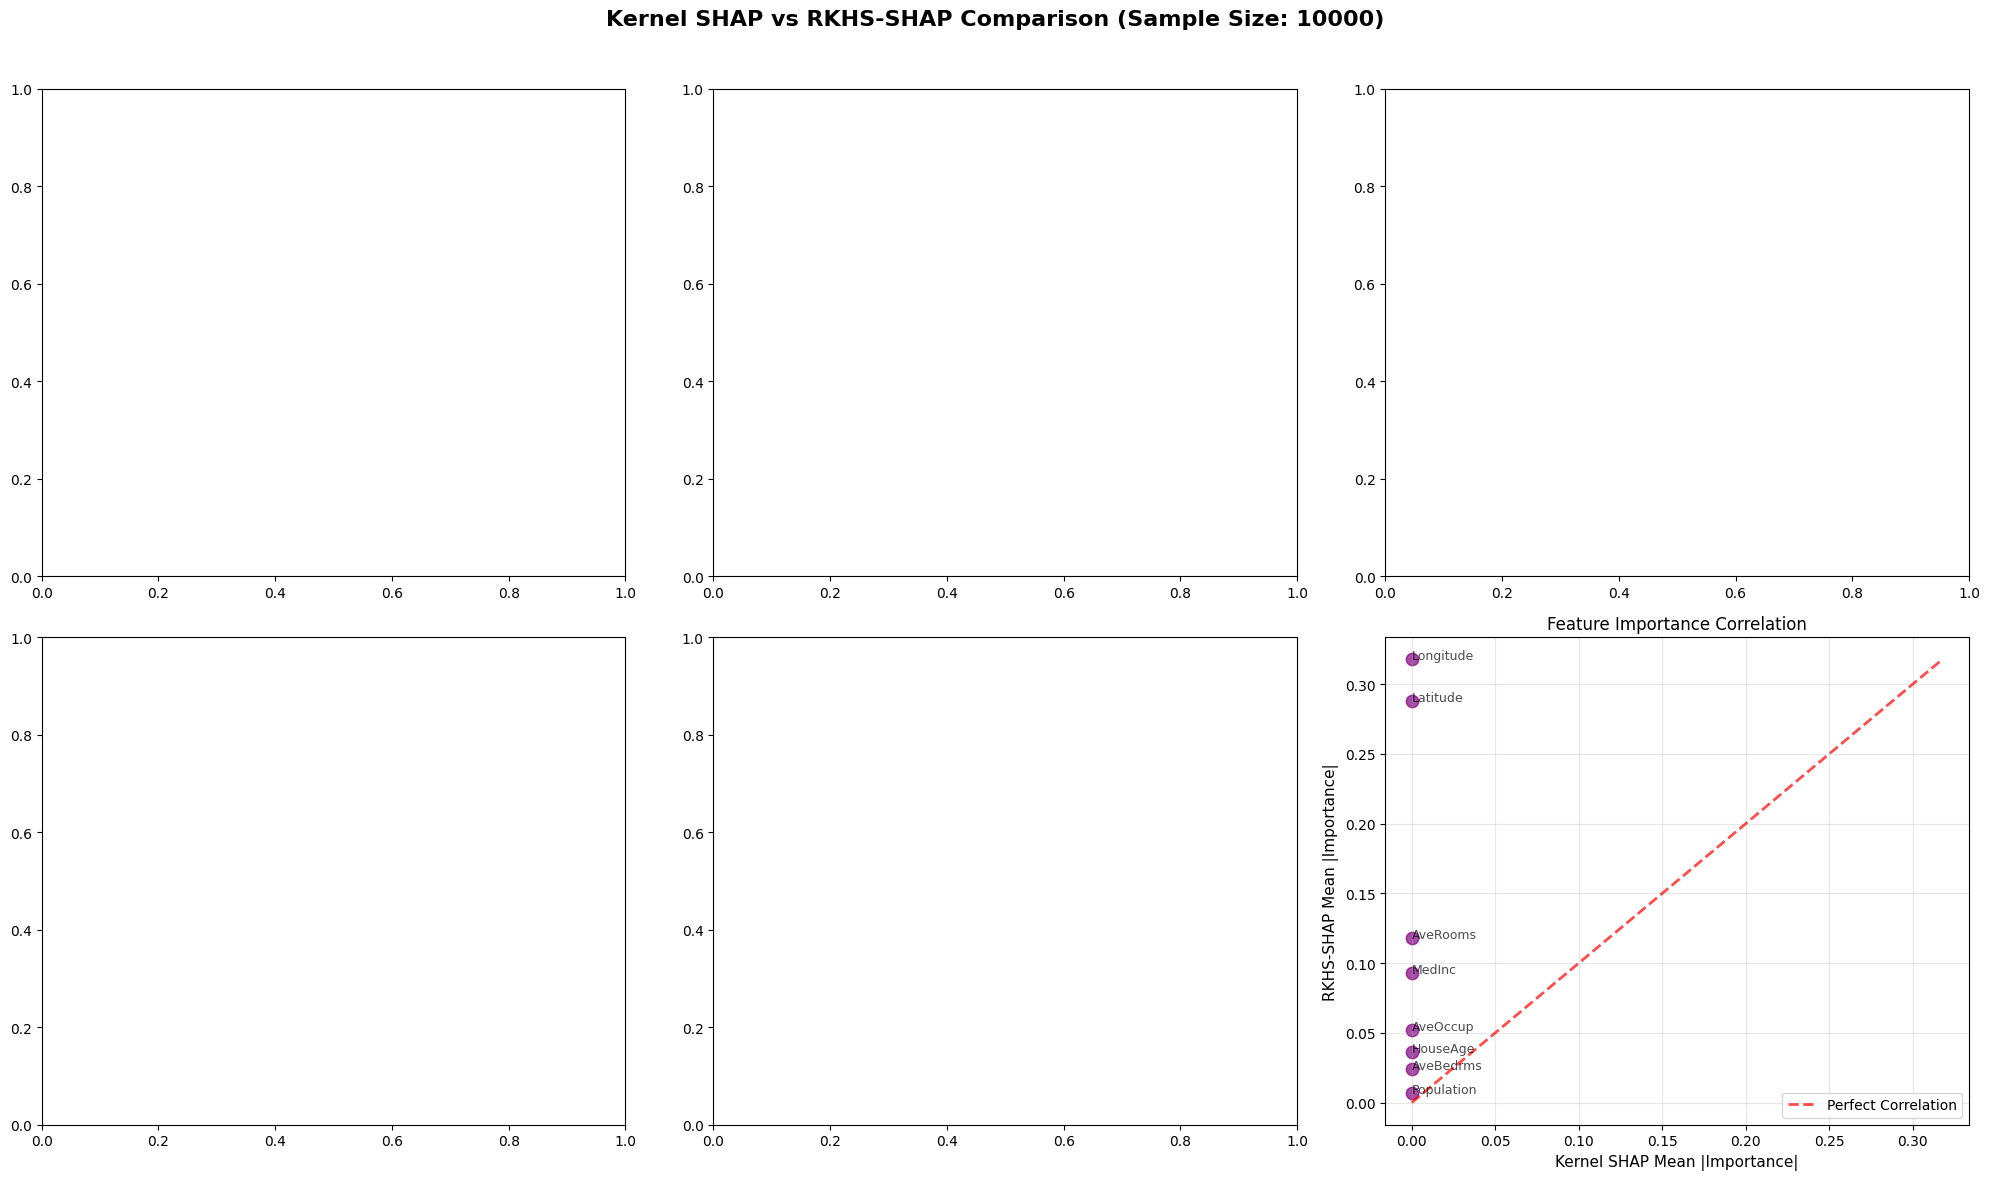

In [6]:
for i, sample_size in enumerate(SAMPLE_SIZES):
    kernel_explanation = all_kernel_explanations[i]
    rkhs_explanation = all_rkhs_explanations[i]
    model = all_models[i]

    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle(
        f"Kernel SHAP vs RKHS-SHAP Comparison (Sample Size: {sample_size})",
        fontsize=16,
        fontweight="bold",
    )

    # Correlation plot between methods
    rkhs_mean_abs = np.mean(np.abs(rkhs_explanation), axis=0)
    kernel_mean_abs = np.zeros_like(rkhs_mean_abs)

    # Kernel SHAP plots
    if kernel_explanation is not None:
        kernel_mean_abs = np.mean(np.abs(kernel_explanation.values), axis=0)
        shap.plots.beeswarm(
            kernel_explanation, ax=axes[0, 0], plot_size=None, show=False
        )
        axes[0, 0].set_title("Kernel SHAP Summary Plot", fontsize=12)

        shap.plots.bar(kernel_explanation, ax=axes[0, 1], show=False)
        axes[0, 1].set_title("Kernel SHAP Global Importance", fontsize=12)

    try:
        # TODO enable creating RKHS Explanation when no Kernel SHAP is present
        # RKHS-SHAP plots
        rkhs_fake_explanation = shap.Explanation(
            values=rkhs_explanation,
            data=kernel_explanation.data,
            feature_names=kernel_explanation.feature_names,
        )

        shap.plots.beeswarm(
            rkhs_fake_explanation, ax=axes[1, 0], plot_size=None, show=False
        )
        axes[1, 0].set_title("RKHS-SHAP Summary Plot", fontsize=12)
        shap.plots.bar(rkhs_fake_explanation, ax=axes[1, 1], show=False)
        axes[1, 1].set_title("RKHS-SHAP Global Importance", fontsize=12)
    except Exception as e:
        print(f"Error plotting RKHS-SHAP explanations: {e}")

    axes[1, 2].scatter(kernel_mean_abs, rkhs_mean_abs, alpha=0.7, s=80, color="purple")

    # Add feature labels
    for j, name in enumerate(feature_names):
        axes[1, 2].annotate(
            name, (kernel_mean_abs[j], rkhs_mean_abs[j]), fontsize=9, alpha=0.7
        )

    # Perfect correlation line
    max_val = max(kernel_mean_abs.max(), rkhs_mean_abs.max())
    axes[1, 2].plot(
        [0, max_val],
        [0, max_val],
        "r--",
        alpha=0.7,
        label="Perfect Correlation",
        linewidth=2,
    )

    axes[1, 2].set_xlabel("Kernel SHAP Mean |Importance|", fontsize=11)
    axes[1, 2].set_ylabel("RKHS-SHAP Mean |Importance|", fontsize=11)
    axes[1, 2].set_title("Feature Importance Correlation", fontsize=12)
    axes[1, 2].legend(fontsize=10)
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()